# Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=df276bb640fea529fe7dc0c519b71e05f78f7dd2ccac687faef4668d09c0b522
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=9c57b4e84aac20eecefb6404ce8d864443bcfd03e4b9847b94c813fd8f7f1bca
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# Download Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


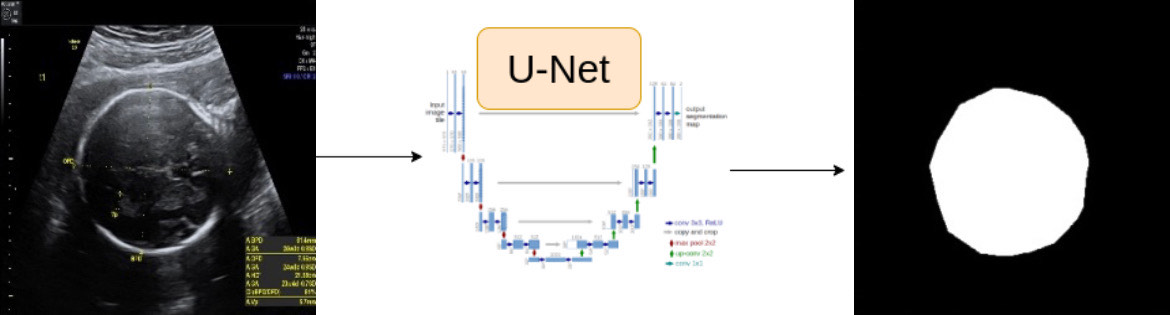

# Some Common Imports

In [3]:
import torch
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Setup Configurations

In [4]:
img_path = "/content/drive/MyDrive/Image_segmentation/all_img"
mask_path = "/content/drive/MyDrive/Image_segmentation/all_masks_bw"

img_files = [f for f in os.listdir(img_path) if f.endswith('.jpeg')]
mask_files = [f for f in os.listdir(mask_path) if f.endswith('.png')]

for f in img_files:
    image = cv2.imread(os.path.join(img_path, f))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite(os.path.join(img_path, f.replace('.jpeg', '.png')), image)

img_files = [f for f in os.listdir(img_path) if f.endswith('.png')]
dataset = [(img_path + '/' + f, mask_path + '/' + f.replace('.png', '.png')) for f in img_files if f.replace('.png', '.png') in mask_files]

df = pd.DataFrame(dataset, columns=['images', 'masks'])
df.to_csv('file.csv', index=False)

In [5]:
CSV_FILE = '/content/file.csv'
DATA_DIR = '/content/'

#DEVICE = 'cpu'

if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

EPOCHS = 50
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 8

Encoder = 'timm-efficientnet-b0'
weights = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,/content/drive/MyDrive/Image_segmentation/all_...,/content/drive/MyDrive/Image_segmentation/all_...
1,/content/drive/MyDrive/Image_segmentation/all_...,/content/drive/MyDrive/Image_segmentation/all_...
2,/content/drive/MyDrive/Image_segmentation/all_...,/content/drive/MyDrive/Image_segmentation/all_...
3,/content/drive/MyDrive/Image_segmentation/all_...,/content/drive/MyDrive/Image_segmentation/all_...
4,/content/drive/MyDrive/Image_segmentation/all_...,/content/drive/MyDrive/Image_segmentation/all_...


In [13]:
row = df.iloc[44]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

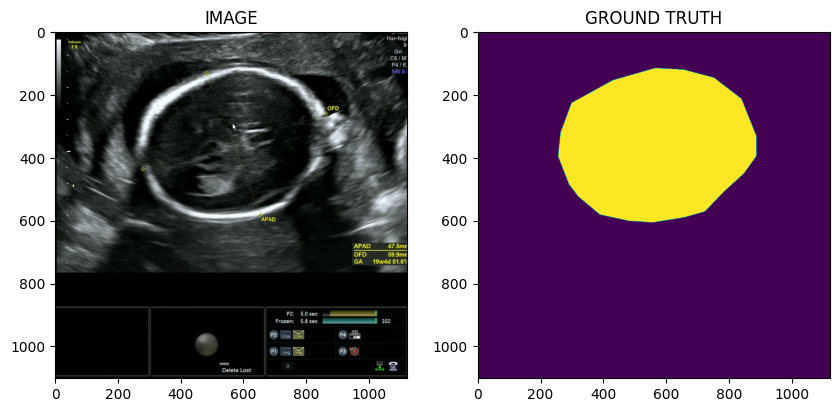

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask)

In [15]:
train_valid_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)
train_df, valid_df = train_test_split(train_valid_df, test_size = 0.2, random_state = 42)

# Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [16]:
import albumentations as A

In [17]:
def get_train_augs():
  return A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.4),
    A.Rotate(limit=45, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.1),
    A.ElasticTransform(alpha=5, sigma=7, alpha_affine=5, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.2),
  ])

def get_valid_augs():
  return A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
  ])


# Create Custom Dataset

In [18]:
from torch.utils.data import Dataset

In [19]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask= np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask


In [20]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())
testset = SegmentationDataset(test_df, get_valid_augs())

In [21]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")
print(f"Size of Testset : {len(testset)}")

Size of Trainset : 86
Size of Validset : 22
Size of Testset : 27


In [22]:
import matplotlib.pyplot as plt

def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

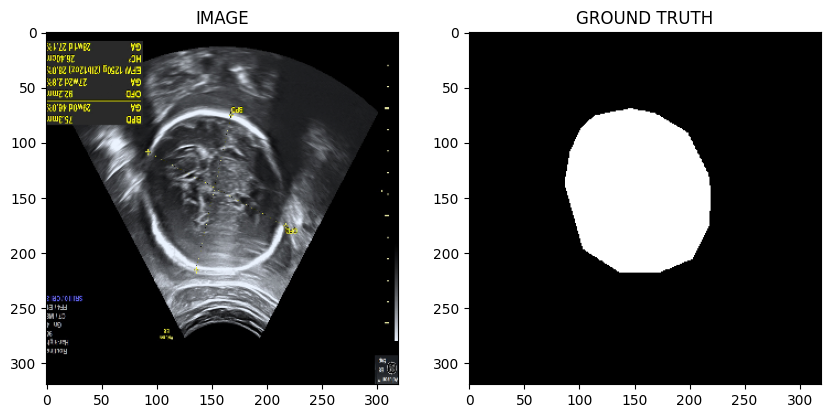

In [25]:
idx = 50

image, mask = trainset[idx]
show_image(image, mask)

# Load dataset into batches

In [26]:
from torch.utils.data import DataLoader

In [27]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [28]:
print(f"total no. of batches in trainloader: {len(trainloader)}")
print(f"total no. of batches in validloader: {len(validloader)}")

total no. of batches in trainloader: 11
total no. of batches in validloader: 3


In [29]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([8, 3, 320, 320])
One batch mask shape : torch.Size([8, 1, 320, 320])


# Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [30]:
from torch import nn
import segmentation_models_pytorch as sample_data
from segmentation_models_pytorch.losses import DiceLoss

In [31]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc=sample_data.Unet(
        encoder_name = Encoder,
        encoder_weights = weights,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:

      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [32]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 70.6MB/s]


# Create Train and Validation Function

In [33]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [34]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Train Model

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [36]:
# Initialize lists to store the loss values for the train set and the validation set
train_loss_list = []
val_loss_list = []

best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  # Append the loss values to the lists
  train_loss_list.append(train_loss)
  val_loss_list.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch _ {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 3/3 [00:10<00:00,  3.57s/it]


SAVED-MODEL
Epoch _ 1 Train_loss : 0.9302707233212211 Valid_loss : 1.5887430508931477


100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


SAVED-MODEL
Epoch _ 2 Train_loss : 0.3264967054128647 Valid_loss : 0.32657034198443097


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


SAVED-MODEL
Epoch _ 3 Train_loss : 0.16585262526165356 Valid_loss : 0.23126166065533957


100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


SAVED-MODEL
Epoch _ 4 Train_loss : 0.14475072581659665 Valid_loss : 0.11641597996155421


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


SAVED-MODEL
Epoch _ 5 Train_loss : 0.11998462812467055 Valid_loss : 0.09601272145907085


100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


SAVED-MODEL
Epoch _ 6 Train_loss : 0.09340085190805522 Valid_loss : 0.06962157040834427


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epoch _ 7 Train_loss : 0.08713729950514706 Valid_loss : 0.0897084300716718


100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Epoch _ 8 Train_loss : 0.09329571913589131 Valid_loss : 0.07677662869294484


100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Epoch _ 9 Train_loss : 0.09126989204775203 Valid_loss : 0.10359520961840947


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch _ 10 Train_loss : 0.07793859460137108 Valid_loss : 0.06968361636002858


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


SAVED-MODEL
Epoch _ 11 Train_loss : 0.07884425669908524 Valid_loss : 0.0637877807021141


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch _ 12 Train_loss : 0.06318066675554622 Valid_loss : 0.0709175392985344


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epoch _ 13 Train_loss : 0.06092750619758259 Valid_loss : 0.0688884233434995


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


SAVED-MODEL
Epoch _ 14 Train_loss : 0.0640516768802296 Valid_loss : 0.057902030646800995


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch _ 15 Train_loss : 0.0561631748622114 Valid_loss : 0.05862662444512049


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


SAVED-MODEL
Epoch _ 16 Train_loss : 0.06073527139696208 Valid_loss : 0.0567677803337574


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch _ 17 Train_loss : 0.05869536575945941 Valid_loss : 0.09960991889238358


100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


SAVED-MODEL
Epoch _ 18 Train_loss : 0.06007412990385836 Valid_loss : 0.053903275479873024


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch _ 19 Train_loss : 0.058174722235311165 Valid_loss : 0.0614779864748319


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch _ 20 Train_loss : 0.057644267651167785 Valid_loss : 0.06360496828953426


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch _ 21 Train_loss : 0.0695722025226463 Valid_loss : 0.05893875037630399


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch _ 22 Train_loss : 0.062389718876643616 Valid_loss : 0.060235776007175446


100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


Epoch _ 23 Train_loss : 0.05901734226129272 Valid_loss : 0.06798221419254939


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch _ 24 Train_loss : 0.06321063908663663 Valid_loss : 0.07486146688461304


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Epoch _ 25 Train_loss : 0.06428912315856326 Valid_loss : 0.06200319156050682


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch _ 26 Train_loss : 0.06074862893332134 Valid_loss : 0.06095347305138906


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch _ 27 Train_loss : 0.0544925680892034 Valid_loss : 0.06715479989846547


100%|██████████| 3/3 [00:01<00:00,  2.72it/s]


Epoch _ 28 Train_loss : 0.05168893526900898 Valid_loss : 0.06305186450481415


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


SAVED-MODEL
Epoch _ 29 Train_loss : 0.04789544641971588 Valid_loss : 0.05312461778521538


100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Epoch _ 30 Train_loss : 0.04680706865408204 Valid_loss : 0.056270889937877655


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epoch _ 31 Train_loss : 0.0541624091565609 Valid_loss : 0.05755847444136938


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch _ 32 Train_loss : 0.056510193781419235 Valid_loss : 0.05844863628347715


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch _ 33 Train_loss : 0.05107459832321514 Valid_loss : 0.05721339707573255


100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Epoch _ 34 Train_loss : 0.04716354439204389 Valid_loss : 0.05324221154054006


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch _ 35 Train_loss : 0.04568109492009336 Valid_loss : 0.05456189066171646


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch _ 36 Train_loss : 0.04549576172774488 Valid_loss : 0.054807079335053764


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch _ 37 Train_loss : 0.04470622065392407 Valid_loss : 0.05459727346897125


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch _ 38 Train_loss : 0.04185803776437586 Valid_loss : 0.059098941584428154


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch _ 39 Train_loss : 0.04372416436672211 Valid_loss : 0.05594154944022497


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch _ 40 Train_loss : 0.04467459564859217 Valid_loss : 0.05792241791884104


100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch _ 41 Train_loss : 0.04413667084141211 Valid_loss : 0.05615100637078285


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch _ 42 Train_loss : 0.04446964270689271 Valid_loss : 0.0533396378159523


100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch _ 43 Train_loss : 0.04367134753953327 Valid_loss : 0.055215660482645035


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch _ 44 Train_loss : 0.04223118112845854 Valid_loss : 0.0550613726178805


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


SAVED-MODEL
Epoch _ 45 Train_loss : 0.04208723015405915 Valid_loss : 0.05274473379055659


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch _ 46 Train_loss : 0.04476905173876069 Valid_loss : 0.057451060662666954


100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


SAVED-MODEL
Epoch _ 47 Train_loss : 0.046031877398490906 Valid_loss : 0.05244472001989683


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


SAVED-MODEL
Epoch _ 48 Train_loss : 0.04106506298888813 Valid_loss : 0.051963565250237785


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


Epoch _ 49 Train_loss : 0.042685056951912964 Valid_loss : 0.053075884779294334


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]

Epoch _ 50 Train_loss : 0.04136946661905809 Valid_loss : 0.05626349523663521


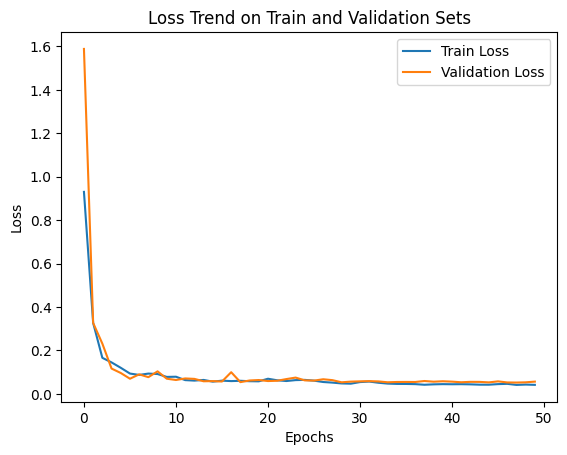

In [37]:
# Plot the loss for the train set and the validation set
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')

# Add labels and title to the plot
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend on Train and Validation Sets')

# Show the legend
plt.legend()

# Save the plot to a file
plt.savefig('loss_trend.png')

# Show the plot
plt.show()

# Inference

<ipython-input-22-864e11315d45>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))


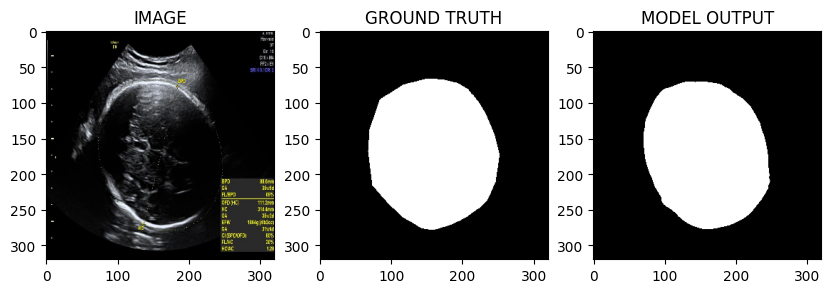

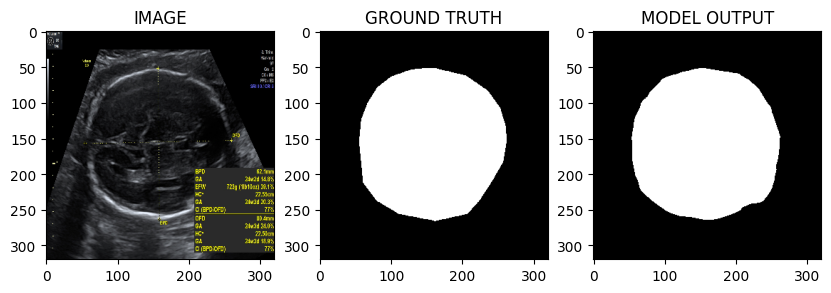

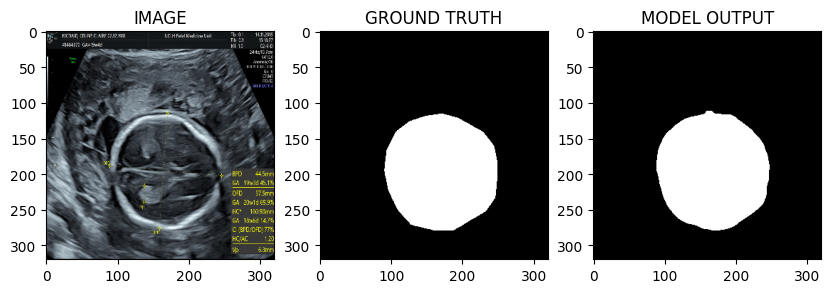

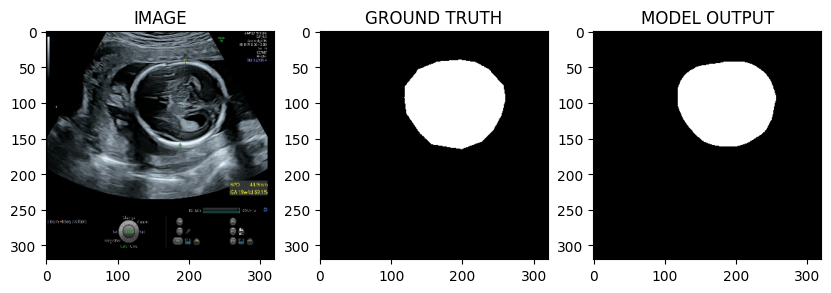

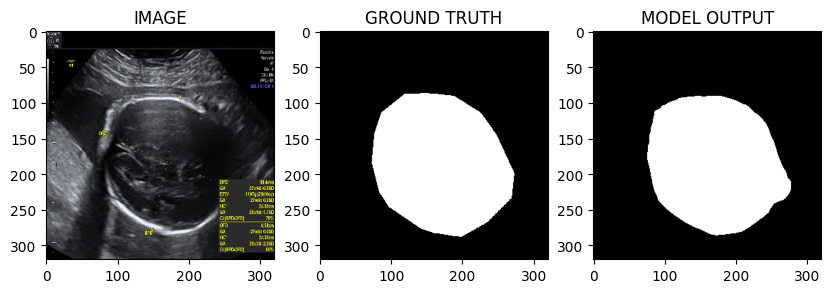

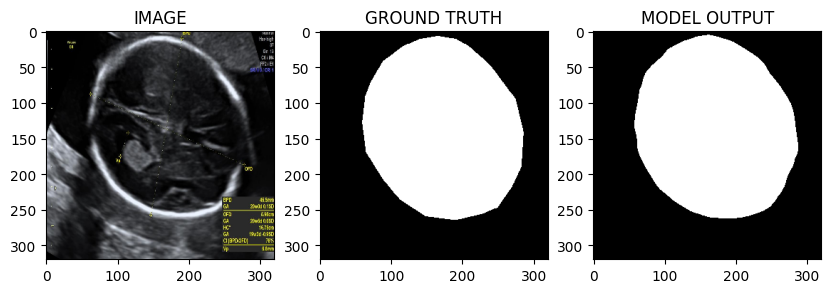

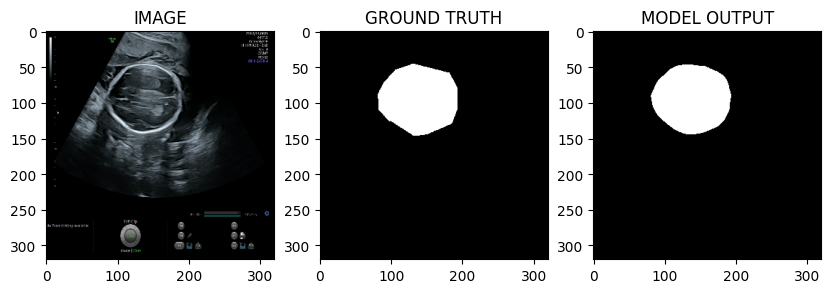

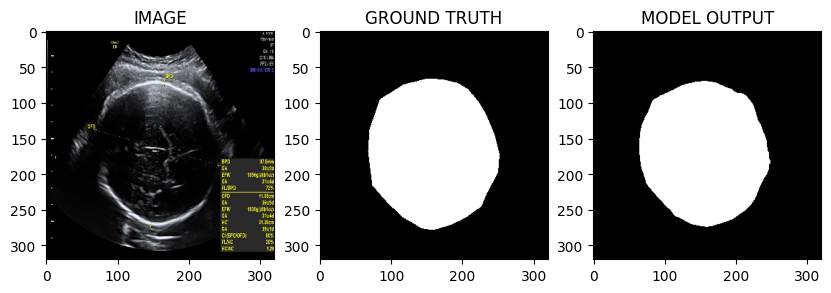

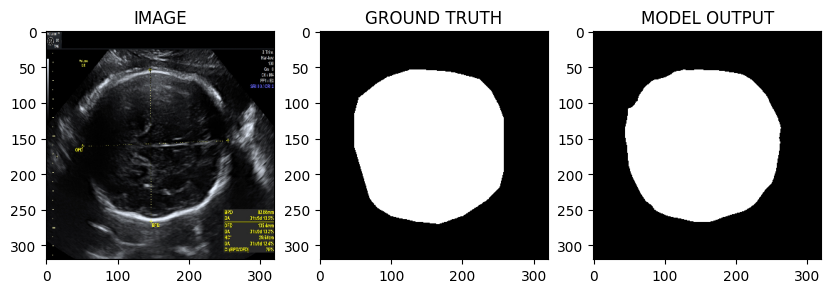

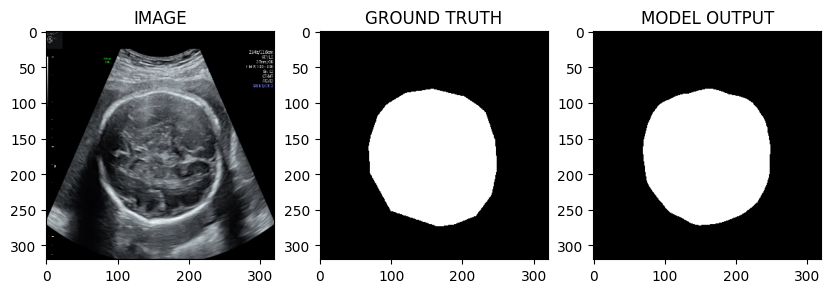

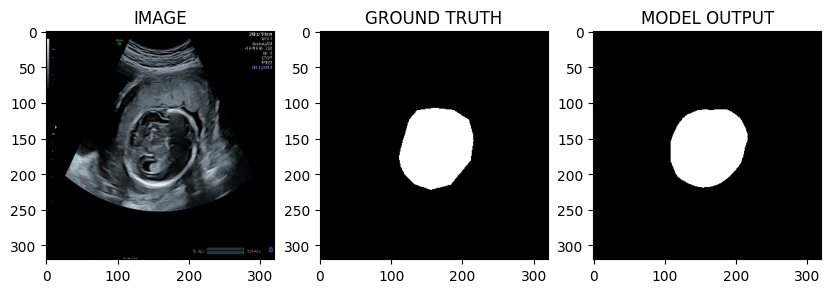

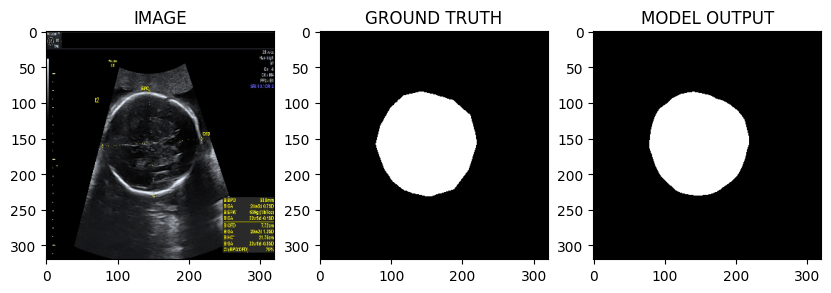

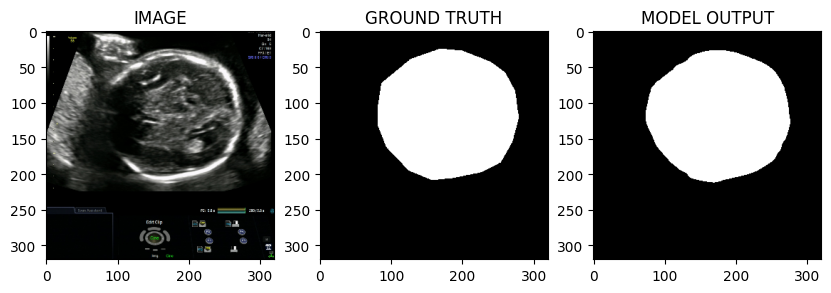

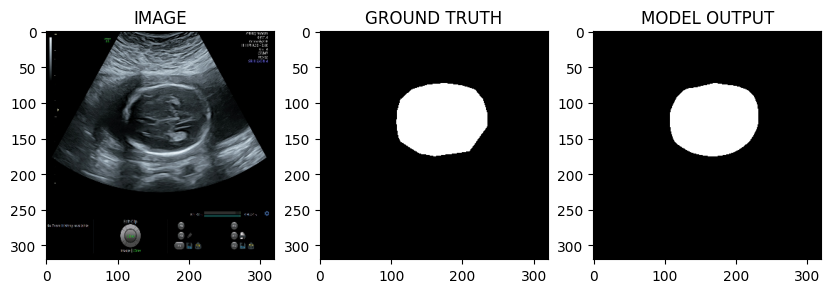

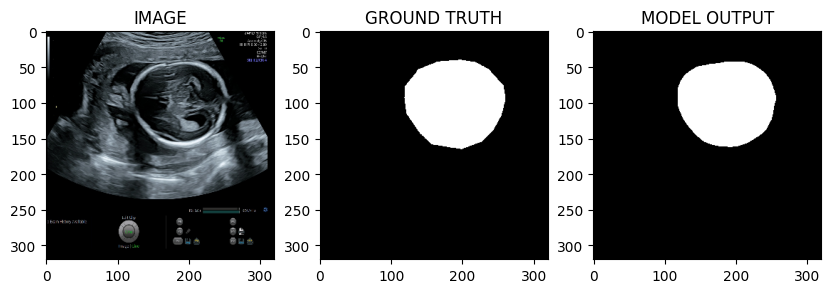

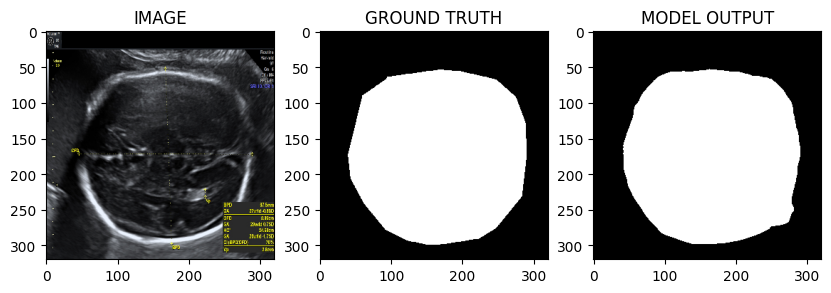

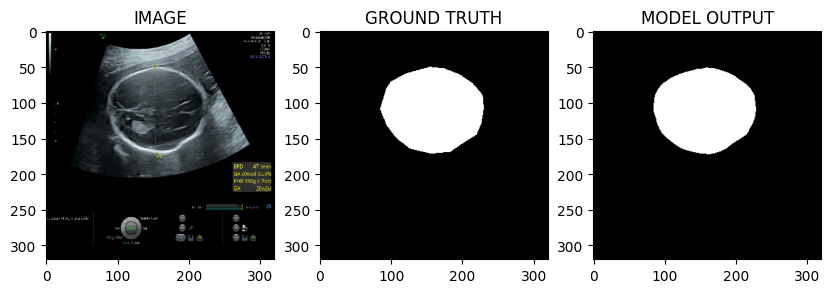

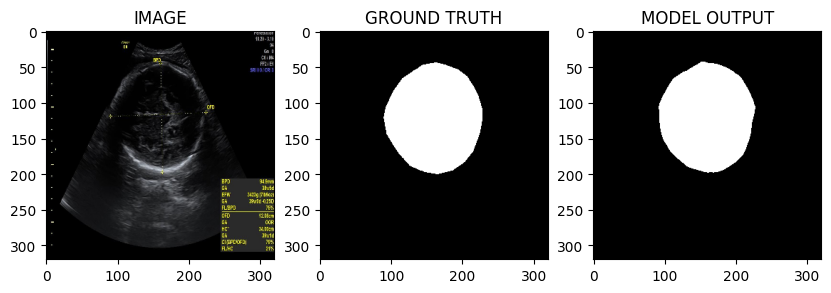

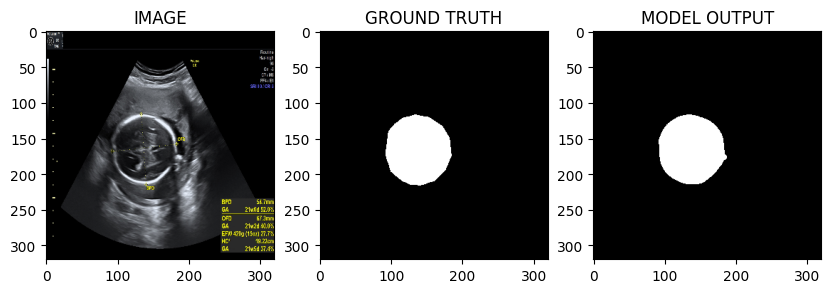

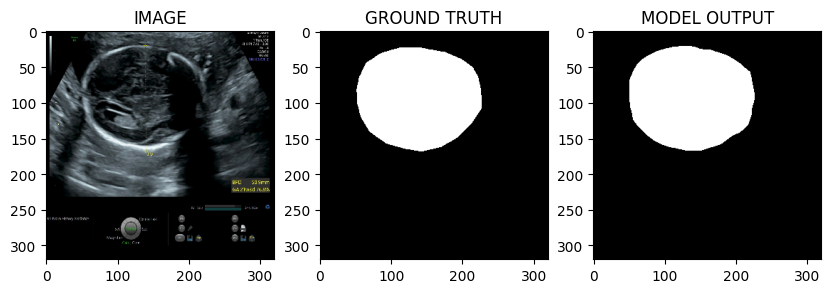

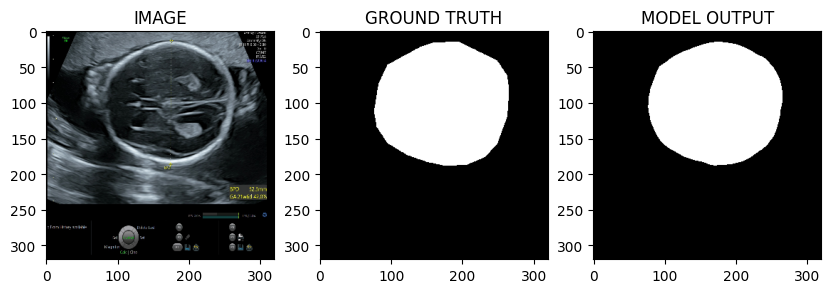

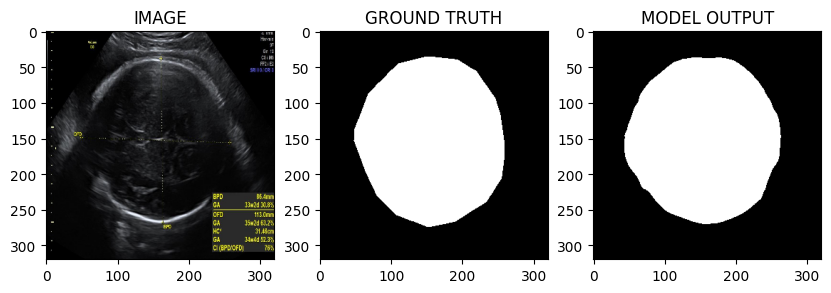

In [38]:
model.load_state_dict(torch.load('/content/best_model.pt'))

model.eval()

with torch.no_grad():
  for idx in range(len(validset)):
    image, mask = validset[idx]
    logits_masks = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
    pred_mask = torch.sigmoid(logits_masks)
    pred_mask = (pred_mask > 0.5)*1.0

    show_image(image, mask, pred_mask.detach().cpu().squeeze(0))


# Iou

In [39]:
def iou(pred, target):
    """
    Compute the Intersection over Union (IoU) between the predicted segmentation and the ground truth segmentation.

    Arguments:
    - pred: a PyTorch tensor of shape (batch_size, H, W) representing the predicted segmentation
    - target: a PyTorch tensor of shape (batch_size, H, W) representing the ground truth segmentation

    Returns:
    - iou: a PyTorch tensor of shape (batch_size) representing the IoU between the predicted segmentation and the ground truth segmentation
    """
    # Convert the tensors to binary arrays
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()

    # Compute the area of overlap
    intersection = (pred * target).sum((1, 2))

    # Compute the area of union
    union = (pred + target).sum((1, 2)) - intersection

    # Compute the IoU
    iou = (intersection + 1e-6) / (union + 1e-6)

    return iou


In [42]:
# Initialize a list to store the IoUs for each image
ious = []

model.eval()

with torch.no_grad():

  for idx, (image, mask) in enumerate(trainset):
    # Compute the predictions
    pred_mask = model(image.to(DEVICE).unsqueeze(0))

    # Move the mask tensor to the same device as the pred_mask tensor
    mask = mask.to(pred_mask.device)

    # Compute the IoU for this image
    iou_value = iou(pred_mask.squeeze(0), mask)

    # Append the computed IoU to the list
    ious.append(iou_value)

  # Calculate the average IoU across all images
  avg_iou = torch.mean(torch.stack(ious))

ious.clear()

# Print the result
print("The average IoU across all {} images in the train set is {:.4f}".format(len(trainset), avg_iou))

The average IoU across all 86 images in the train set is 0.9645


In [44]:
# Initialize a list to store the IoUs for each image
ious = []

model.eval()

with torch.no_grad():

  for idx, (image, mask) in enumerate(validset):
    # Compute the predictions
    pred_mask = model(image.to(DEVICE).unsqueeze(0))

    # Move the mask tensor to the same device as the pred_mask tensor
    mask = mask.to(pred_mask.device)

    # Compute the IoU for this image
    iou_value = iou(pred_mask.squeeze(0), mask)

    # Append the computed IoU to the list
    ious.append(iou_value)

  # Calculate the average IoU across all images
  avg_iou = torch.mean(torch.stack(ious))

ious.clear()

# Print the result
print("The average IoU across all {} images in the validation set is {:.4f}".format(len(validset), avg_iou))

The average IoU across all 22 images in the validation set is 0.9553


In [45]:
# Initialize a list to store the IoUs for each image
ious = []

model.eval()

with torch.no_grad():
  for idx, (image, mask) in enumerate(testset):
    # Compute the predictions
    pred_mask = model(image.to(DEVICE).unsqueeze(0))

    # Move the mask tensor to the same device as the pred_mask tensor
    mask = mask.to(pred_mask.device)

    # Compute the IoU for this image
    iou_value = iou(pred_mask.squeeze(0), mask)

    # Append the computed IoU to the list
    ious.append(iou_value)

  # Calculate the average IoU across all images
  avg_iou = torch.mean(torch.stack(ious))

ious.clear()

# Print the result
print("The average IoU across all {} images in the test set is {:.4f}".format(len(testset), avg_iou))

The average IoU across all 27 images in the test set is 0.9578
